Imports

In [1]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T
from torchvision import datasets
import matplotlib.pyplot as plt
import PIL

# Install Hugging Face Datasets

In [1]:
#Install the Hugging Face Datasets library if you haven't already:
!pip install datasets

Downloading the [Tiny ImageNet dataset](https://huggingface.co/datasets/zh-plus/tiny-imagenet)

In [2]:
from datasets import load_dataset

# Load the train split of the Tiny ImageNet dataset
# Load the train, and validation of the Tiny ImageNet dataset
## we can split the training dataset to be having training and validation datasets

train_dataset = load_dataset('zh-plus/tiny-imagenet', split='train')
# split the training dataset into training and validation datasets
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset,[90000,10000])

test_dataset = load_dataset('zh-plus/tiny-imagenet', split='valid')

## Check For Gray scale Images in the dataset

In [ ]:
# Define a transform to convert images to tensors
transform = T.ToTensor()

# Function to check the size and number of channels of images in a dataset
def check_image_sizes_and_channels(dataset):
  counter_gray = 0
  for idx in range(len(dataset)): #idx in [0 ----89999]
        image = dataset[idx]['image']
        image_tensor = transform(image)
        channels, height, width = image_tensor.shape
        if channels != 3:
            counter_gray += 1
            #print(channels)
  print (f"Dataset contains {counter_gray} Gray scale images")

# Check image sizes and number of channels in the training dataset
check_image_sizes_and_channels(train_dataset)

Dataset contains 1646 Gray scale images


Filter the train,test, valid datasets from gray-scale images

In [3]:
# Define a transform to convert images to tensors
transform = T.ToTensor()

# Function to filter out grayscale images
def filter_rgb_images(dataset):
    filtered_dataset = []
    for idx in range(len(dataset)):
        image = dataset[idx]['image']
        image_tensor = transform(image)
        channels, height, width = image_tensor.shape
        if channels == 3:
            filtered_dataset.append(dataset[idx])

    return filtered_dataset

# Filter the training, testing and validation datasets
filtered_train_dataset = filter_rgb_images(train_dataset)
filtered_valid_dataset = filter_rgb_images(valid_dataset)
filtered_test_dataset = filter_rgb_images(test_dataset)

# Display the number of images in the filtered datasets
print(f"Number of images in the filtered training dataset: {len(filtered_train_dataset)}")
print(f"Number of images in the filtered validation dataset: {len(filtered_valid_dataset)}")
print(f"Number of images in the filtered testing dataset: {len(filtered_test_dataset)}")

Number of images in the filtered training dataset: 88356
Number of images in the filtered validation dataset: 9823
Number of images in the filtered testing dataset: 9832


In [ ]:
transform(filtered_train_dataset[4]['image']).shape

torch.Size([3, 64, 64])

In [ ]:
#Find shape of each image
print(transform(filtered_train_dataset[0]['image']).shape)


torch.Size([3, 64, 64])


In [ ]:
#Show some images and labels (200 classes For tiny ImageNet)
#filtered_train_dataset[5]['image']
print(filtered_train_dataset[5]['label'])

149


# Integrate the dataset with PyTorch for use in a neural network



1.   Create Custom DataClass For that dataset
2.   Create DataLoaders using the DataClasses




---






In [4]:
#Create Custom Dataset object Since Tiny Image net doesn't have a Pytorch Dataset Object already created
#Unlike Fashion Mnist and Hand written Digits

class TinyImageNetDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        label = self.dataset[idx]['label']

        if self.transform:
            image = self.transform(image)

        return image, label

Adding all together

In [5]:
#Data Augmentation is done for the training datset and not for validation or testing, Correct?

import torchvision.transforms as T
train_transform = T.Compose([T.RandomAffine(translate =(0.1,0.1), degrees=0,  interpolation = T.InterpolationMode.BILINEAR ),
                                T.ColorJitter(brightness=(0.5,1),contrast=(0.5,1)),
                                T.RandomHorizontalFlip(p=0.2),
                                T.Resize(68),
                                T.CenterCrop(64),
                                T.ToTensor(),
                                T.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
                               ])

valid_transform = T.Compose ([T.Resize(68),
    T.CenterCrop(64),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
#ToDo: Initialize the three data classes and Three dataloaders
train_dataClass = TinyImageNetDataset(filtered_train_dataset, transform = train_transform)
test_dataClass = TinyImageNetDataset(filtered_test_dataset, transform   = valid_transform)
valid_dataClass = TinyImageNetDataset(filtered_valid_dataset, transform = valid_transform)

#Create DataLoader For Each Dataset
TrainLoader = DataLoader(train_dataClass, batch_size=32, shuffle=True)
TestLoader  = DataLoader(test_dataClass, batch_size=32, shuffle=True)
ValidLoader = DataLoader(valid_dataClass, batch_size=32, shuffle=True)



# Batch Normalization in CNN Architecture

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MyCNN(nn.Module):
    def __init__(self):
        # We optimize dropout rate in a convolutional neural network.
        super(MyCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3, out_channels=16, kernel_size=3, stride=1, padding= 1)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1)
        #ToDo: Create a seconed Batch normalization layer called self.bn2
        self.bn2 = nn.BatchNorm2d(32)

        self.drop=nn.Dropout2d(p=0.2)

        ## ToDo: Create a MaxPool Layer of size (2,2) name it self.pool
        self.pool = nn.MaxPool2d(kernel_size = 2)

        self.fc1 = nn.Linear(8192, 4096)  #2^12 = 4096
        self.bn3 = nn.BatchNorm1d(4096)   ###### Notice BatchNorm1d
        self.fc2 = nn.Linear(4096, 1024)  #1024 = 2^10
        self.bn4 = nn.BatchNorm1d(1024)   ###### Notice BatchNorm1d
        self.fc3 = nn.Linear(1024, 200)   # 200 classes


    def forward(self, x):

        x = self.pool(self.bn1(F.relu(self.conv1(x))))  #  3 x 64 x 64 ->  16 x 64 x 64 ->  16 x 32 x 32
        x = self.pool(self.bn2(F.relu(self.conv2(x))))  # 16 x 32 x 32   -->  32 x 32 x 32 ->  32 x 16 x 16
        x = self.drop(x)

        x = x.view(x.size(0),-1)             #32 x 16 x 16 -->8192

        x = self.bn3(F.relu(self.fc1(x)))    #8192 ->4096
        x = self.bn4(F.relu(self.fc2(x)))    #4096 ->1024
        x = self.fc3(x)                      #1024--> 200 #No Softmax or Logsoftmax activation layer added

        return x

# Do not change the name of yo'ur model or later cells may fail!
model = MyCNN()
model.to(device)

MyCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout2d(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=4096, bias=True)
  (bn3): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=4096, out_features=1024, bias=True)
  (bn4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=1024, out_features=200, bias=True)
)

### Specify Optimizer and Losse

In [8]:
#Use adam Optimizer (LR=0.002) and Cross Entropy as a loss function
optimizer = optim.Adam(model.parameters(), lr=0.002)
criterion =  nn.CrossEntropyLoss()

In [9]:
# Saving the model with the highest Validation accuracy
# Tracing Losses and accuracies and saving them in a dictionary called "history"

history={'train_loss':[],'valid_loss':[],'train_acc':[],'valid_acc':[]}
num_epochs=10
Validation_loss=float("inf")

for epoch in range(num_epochs):
    train_loss,train_correct=0.0,0

    model.train()
    for images, labels in TrainLoader:

        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()     #Correctly classified Images

    valid_loss, val_correct = 0.0, 0

    model.eval()
    for images, labels in ValidLoader:

        images,labels = images.to(device),labels.to(device)
        output = model(images)
        loss=criterion(output,labels)
        valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data,1)
        val_correct += (predictions == labels).sum().item()

    train_loss = train_loss / len(TrainLoader.sampler)
    train_acc = train_correct / len(TrainLoader.sampler)*100
    valid_loss = valid_loss / len(ValidLoader.sampler)
    valid_acc = val_correct / len(ValidLoader.sampler) * 100

    print("Epoch:{}/{} \t AVERAGE TL:{:.4f} AVERAGE VL:{:.4f} \t AVERAGE TA:{:.2f} %  AVERAGE VA:{:.2f} %".format(epoch + 1, num_epochs,
                                                                                         train_loss,
                                                                                         valid_loss,
                                                                                         train_acc,
                                                                                        valid_acc))
    #Check for best validation loss and use corresponding model
    if valid_loss< Validation_loss:
        Validation_loss=valid_loss
        best_model_state = model.state_dict()

    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    history['train_acc'].append(train_acc)
    history['valid_acc'].append(valid_acc)

torch.save(best_model_state, 'Best_model.pth')

Epoch:1/10 	 AVERAGE TL:4.7273 AVERAGE VL:4.1668 	 AVERAGE TA:6.95 %  AVERAGE VA:12.00 %
Epoch:2/10 	 AVERAGE TL:4.0885 AVERAGE VL:3.8219 	 AVERAGE TA:12.79 %  AVERAGE VA:16.97 %
Epoch:3/10 	 AVERAGE TL:3.8965 AVERAGE VL:4.3139 	 AVERAGE TA:15.59 %  AVERAGE VA:13.48 %
Epoch:4/10 	 AVERAGE TL:3.7769 AVERAGE VL:3.6776 	 AVERAGE TA:17.45 %  AVERAGE VA:20.20 %
Epoch:5/10 	 AVERAGE TL:3.6415 AVERAGE VL:3.5132 	 AVERAGE TA:19.62 %  AVERAGE VA:22.29 %
Epoch:6/10 	 AVERAGE TL:3.6561 AVERAGE VL:3.7063 	 AVERAGE TA:19.58 %  AVERAGE VA:22.41 %
Epoch:7/10 	 AVERAGE TL:3.5916 AVERAGE VL:3.5746 	 AVERAGE TA:20.52 %  AVERAGE VA:22.73 %
Epoch:8/10 	 AVERAGE TL:3.5117 AVERAGE VL:3.8832 	 AVERAGE TA:21.71 %  AVERAGE VA:19.19 %
Epoch:9/10 	 AVERAGE TL:3.5279 AVERAGE VL:4.7527 	 AVERAGE TA:21.66 %  AVERAGE VA:21.40 %
Epoch:10/10 	 AVERAGE TL:3.4569 AVERAGE VL:9.4826 	 AVERAGE TA:22.72 %  AVERAGE VA:24.15 %


### Complexity Graph

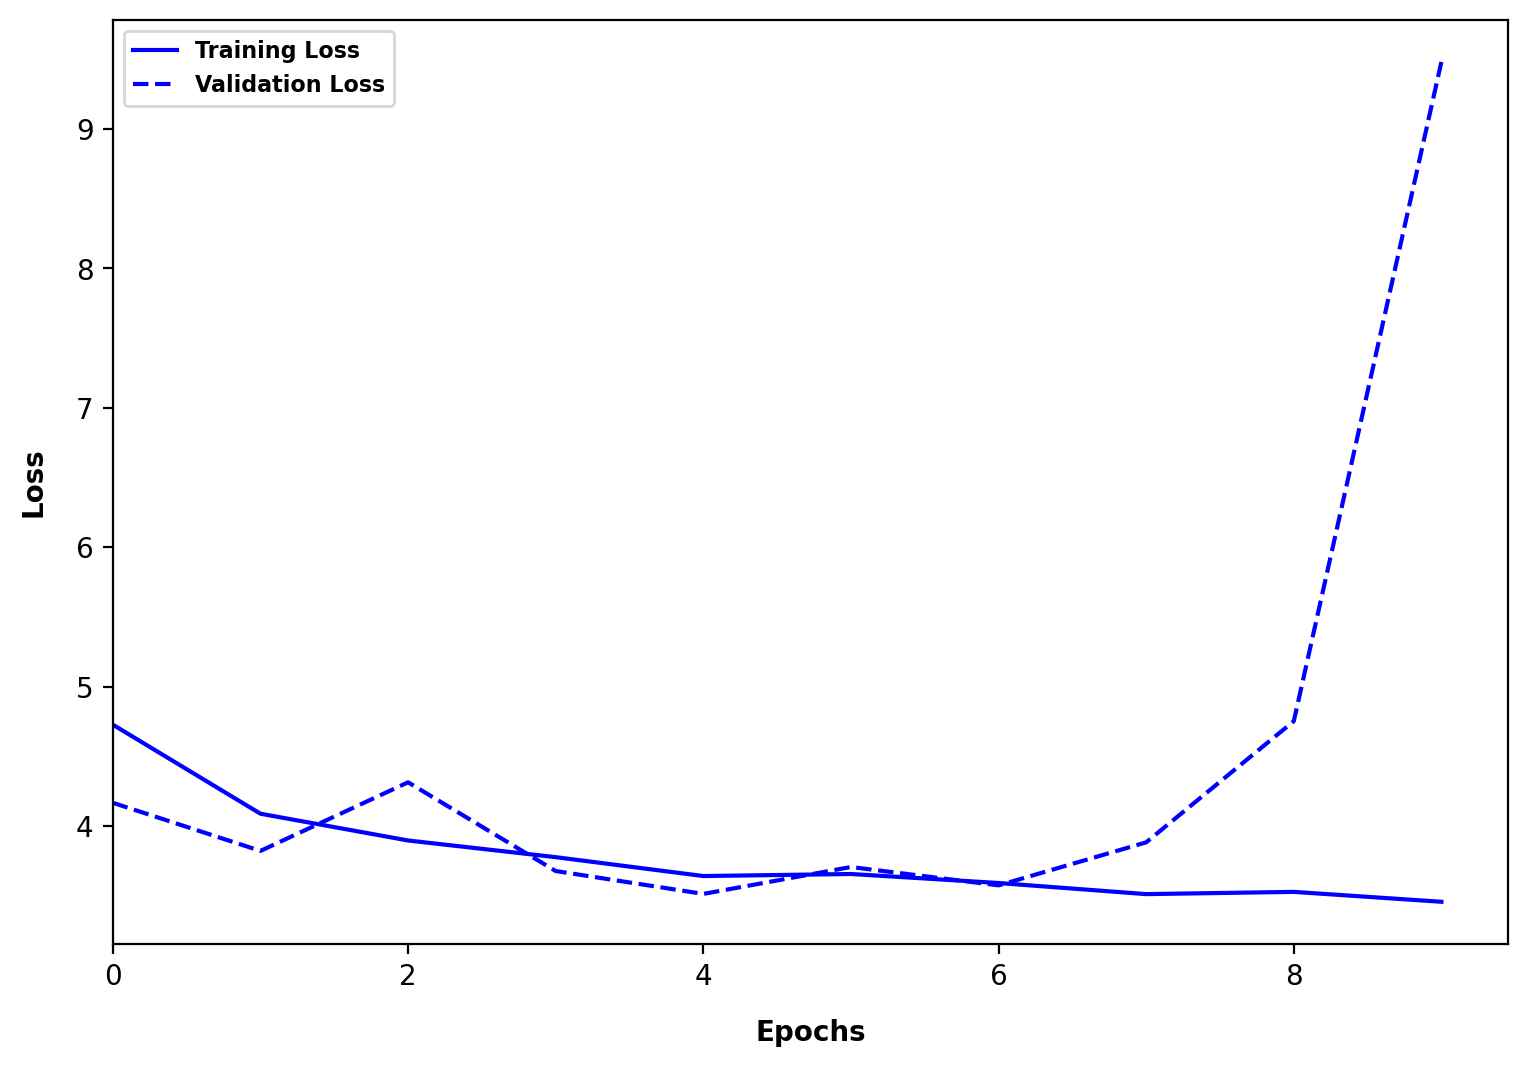

In [10]:

epochs=10
fig=plt.figure(figsize=(9,6),dpi=200)
x=[epoch for epoch in range(epochs)]
plt.plot(x,history['train_loss'],'b',label='Training Loss')
plt.plot(x,history['valid_loss'],'b',linestyle='dashed',label='Validation Loss')

plt.xlabel("Epochs",fontweight='bold',labelpad=10)
plt.ylabel("Loss",fontweight='bold',labelpad=10)
plt.xlim(xmin = 0)

plt.legend(prop={'size': 8,'weight':'bold'},loc="best")

plt.savefig(r'Losses.png',bbox_inches="tight")
plt.show()

### Testing your model

In [11]:
model.load_state_dict(torch.load('Best_model.pth', map_location=device))

correct = 0
total = 0
test_loss = 0
with torch.no_grad():

    for images, labels in TestLoader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs,labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss = test_loss / len(TestLoader.sampler)

print('Accuracy of the network on the test images: {:.2f} %%'.format(100 * correct / total))
print('Loss of the network on the test images: {:.4f}'.format(test_loss))

Accuracy of the network on the test images: 23.58 %%
Loss of the network on the test images: 9.9127


### Add SE Block

In [27]:
class SEBlock(nn.Module):
    def __init__(self,in_channels):
        super(SEBlock, self).__init__()
        self.in_channels = in_channels
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1) #Averaging the pixels in one channel to give one final output
        self.fc1 = nn.Linear(self.in_channels , 8)  #n.channels
        self.fc2 = nn.Linear(8 , self.in_channels)  #n.channels

    def forward(self,x):
        se_tensor = self.global_avg_pool(x)                              # (Batches, Channels)
        se_tensor = se_tensor.view(se_tensor.size(0), -1)                #Put in 1D array
        se_tensor = F.relu(self.fc1(se_tensor))                          #(Batches, Channels)
        se_tensor = torch.sigmoid(self.fc2(se_tensor))
        # Reshape to (batch_size, channels, 1, 1) to multiply by input
        se_tensor = se_tensor.view(se_tensor.size(0), se_tensor.size(1), 1, 1)
        # Multiply the original feature maps by the SE tensor
        x = x * se_tensor
        return x

### Create CNN Model architecture

In [28]:
class MyCNN(nn.Module):
    def __init__(self):
        # We optimize dropout rate in a convolutional neural network.
        super(MyCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3, out_channels=16, kernel_size=3, stride=1, padding= 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.se_block1 = SEBlock(in_channels=16)


        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.se_block2 = SEBlock(in_channels=32)

        self.drop=nn.Dropout2d(p=0.2)

        self.pool = nn.MaxPool2d(kernel_size = 2)

        self.fc1 = nn.Linear(8192, 4096) #2^12 = 4096
        self.bn3 = nn.BatchNorm1d(4096)   ###### Notice BatchNorm1d
        self.fc2 = nn.Linear(4096, 1024) #1024 = 2^10
        self.bn4 = nn.BatchNorm1d(1024)   ###### Notice BatchNorm1d
        self.fc3 = nn.Linear(1024, 200)   # 200 classes

    def forward(self, x):

        x = self.bn1(F.relu(self.conv1(x)))
        x = self.se_block1(x)
        x = self.pool(x)

        x = self.bn2(F.relu(self.conv2(x)))
        x = self.se_block2(x)
        x = self.pool(x)
        
        x = self.drop(x)

        x = x.view(x.size(0),-1)                    #32 x 16 x 16 -->8192

        x = self.bn3(F.relu(self.fc1(x)))           #8192 ->4096
        x = self.bn4(F.relu(self.fc2(x)))           #4096 ->1024
        x = self.fc3(x)                             #1024--> 200 #No Softmax or Logsoftmax activation layer added

        return x

# Do not change the name of your model or later cells may fail!
model = MyCNN()
model.to(device)

MyCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (se_block1): SEBlock(
    (global_avg_pool): AdaptiveAvgPool2d(output_size=1)
    (fc1): Linear(in_features=16, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=16, bias=True)
  )
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (se_block2): SEBlock(
    (global_avg_pool): AdaptiveAvgPool2d(output_size=1)
    (fc1): Linear(in_features=32, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=32, bias=True)
  )
  (drop): Dropout2d(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=4096, bias=True)
  (bn3): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=

### Specify Optimizer and Losse

In [30]:
#Use adam Optimizer (LR=0.002) and Cross Entropy as a loss function
optimizer = optim.Adam(model.parameters(), lr=0.002)
criterion =  nn.CrossEntropyLoss()

In [31]:
# Saving the model with the highest Validation accuracy
# Tracing Losses and accuracies and saving them in a dictionary called "history"

history={'train_loss':[],'valid_loss':[],'train_acc':[],'valid_acc':[]}
num_epochs=10
Validation_loss=float("inf")

for epoch in range(num_epochs):
    train_loss,train_correct=0.0,0

    model.train()
    for images, labels in TrainLoader:

        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()     #Correctly classified Images

    valid_loss, val_correct = 0.0, 0

    model.eval()
    for images, labels in ValidLoader:

        images,labels = images.to(device),labels.to(device)
        output = model(images)
        loss=criterion(output,labels)
        valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data,1)
        val_correct += (predictions == labels).sum().item()

    train_loss = train_loss / len(TrainLoader.sampler)
    train_acc = train_correct / len(TrainLoader.sampler)*100
    valid_loss = valid_loss / len(ValidLoader.sampler)
    valid_acc = val_correct / len(ValidLoader.sampler) * 100

    print("Epoch:{}/{} \t AVERAGE TL:{:.4f} AVERAGE VL:{:.4f} \t AVERAGE TA:{:.2f} %  AVERAGE VA:{:.2f} %".format(epoch + 1, num_epochs,
                                                                                         train_loss,
                                                                                         valid_loss,
                                                                                         train_acc,
                                                                                        valid_acc))
    #Check for best validation loss and use corresponding model
    if valid_loss< Validation_loss:
        Validation_loss=valid_loss
        best_model_state = model.state_dict()

    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    history['train_acc'].append(train_acc)
    history['valid_acc'].append(valid_acc)

torch.save(best_model_state, 'Best_model.pth')

Epoch:1/10 	 AVERAGE TL:4.7553 AVERAGE VL:4.2411 	 AVERAGE TA:6.91 %  AVERAGE VA:11.79 %
Epoch:2/10 	 AVERAGE TL:4.0029 AVERAGE VL:3.8547 	 AVERAGE TA:13.87 %  AVERAGE VA:16.25 %
Epoch:3/10 	 AVERAGE TL:3.8107 AVERAGE VL:3.6071 	 AVERAGE TA:16.98 %  AVERAGE VA:20.34 %
Epoch:4/10 	 AVERAGE TL:3.6642 AVERAGE VL:3.6663 	 AVERAGE TA:19.27 %  AVERAGE VA:20.63 %
Epoch:5/10 	 AVERAGE TL:3.5410 AVERAGE VL:3.4505 	 AVERAGE TA:21.08 %  AVERAGE VA:23.83 %
Epoch:6/10 	 AVERAGE TL:3.4846 AVERAGE VL:3.4306 	 AVERAGE TA:22.31 %  AVERAGE VA:24.49 %
Epoch:7/10 	 AVERAGE TL:3.3679 AVERAGE VL:3.4926 	 AVERAGE TA:24.17 %  AVERAGE VA:23.63 %
Epoch:8/10 	 AVERAGE TL:3.3596 AVERAGE VL:3.3704 	 AVERAGE TA:24.27 %  AVERAGE VA:25.72 %
Epoch:9/10 	 AVERAGE TL:3.2714 AVERAGE VL:3.4589 	 AVERAGE TA:25.80 %  AVERAGE VA:24.91 %
Epoch:10/10 	 AVERAGE TL:3.3011 AVERAGE VL:3.3114 	 AVERAGE TA:25.50 %  AVERAGE VA:27.25 %


## Transfer Learning 

We will use ResNet 18 that was trained previously. We can see the model architecture on [ Netron](https://netron.app/). The dataset it was trained on was of size 224 x 224


In [34]:
import torchvision.models
model = torchvision.models.resnet18()

In [50]:
print(model.fc.out_features)
print(model.fc.in_features)

1000
512


In [51]:
# Fake image needed for torch.jit.trace
# (adjust the size of the image from 224x224 to what the
# network expects if needed)
random_image = torch.rand((1, 3, 224, 224))

scripted = torch.jit.trace(model, random_image)
torch.jit.save(scripted, "my_network.pt")

In [35]:
#ToDo: Change the number of classes to be identical to the ones you have in your dataset
num_classes= 200
model.fc = nn.Linear(model.fc.in_features, num_classes) 

Freezing the model parameters but not the final layer. 

In [53]:
#Parameter freezing
for param in model.parameters():
    param.requires_grad = False
#Don't freeze FC layer parameters:
for param in model.fc.parameters():
    param.requires_grad = True

Resnet 18 was trained on 224 x 224 images

In [36]:
#Data Augmentation is done for the training datset and not for validation or testing, Correct?
#ToDo: Resize the images to be of size 24 x 24
import torchvision.transforms as T
train_transform = T.Compose([T.Resize((224,224)),
                             T.RandomAffine(translate =(0.1,0.1), degrees=0,  interpolation = T.InterpolationMode.BILINEAR ),
                             T.ColorJitter(brightness=(0.5,1),contrast=(0.5,1)),
                             T.RandomHorizontalFlip(p=0.2),
                             T.ToTensor(),
                             T.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
                               ])

valid_transform = T.Compose ([T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [55]:
#Initialize the three data classes and Three dataloaders
train_dataClass = TinyImageNetDataset(filtered_train_dataset, transform = train_transform)
test_dataClass = TinyImageNetDataset(filtered_test_dataset, transform   = valid_transform)
valid_dataClass = TinyImageNetDataset(filtered_valid_dataset, transform = valid_transform)

#Create DataLoader For Each Dataset
TrainLoader = DataLoader(train_dataClass, batch_size=32, shuffle=True)
TestLoader  = DataLoader(test_dataClass, batch_size=32, shuffle=True)
ValidLoader = DataLoader(valid_dataClass, batch_size=32, shuffle=True)


In [56]:
#Use adam Optimizer (LR=0.002) and Cross Entropy as a loss function
optimizer = optim.Adam(model.parameters(), lr=0.002)
criterion =  nn.CrossEntropyLoss()

In [11]:
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

NameError: name 'model' is not defined

In [47]:
# Saving the model with the highest Validation accuracy
# Tracing Losses and accuracies and saving them in a dictionary called "history"

history={'train_loss':[],'valid_loss':[],'train_acc':[],'valid_acc':[]}
num_epochs=10
Validation_loss=float("inf")

for epoch in range(num_epochs):
    train_loss,train_correct=0.0,0

    model.train()
    for images, labels in TrainLoader:

        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()     #Correctly classified Images

    valid_loss, val_correct = 0.0, 0

    model.eval()
    for images, labels in ValidLoader:

        images,labels = images.to(device),labels.to(device)
        output = model(images)
        loss=criterion(output,labels)
        valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data,1)
        val_correct += (predictions == labels).sum().item()

    train_loss = train_loss / len(TrainLoader.sampler)
    train_acc = train_correct / len(TrainLoader.sampler)*100
    valid_loss = valid_loss / len(ValidLoader.sampler)
    valid_acc = val_correct / len(ValidLoader.sampler) * 100

    print("Epoch:{}/{} \t AVERAGE TL:{:.4f} AVERAGE VL:{:.4f} \t AVERAGE TA:{:.2f} %  AVERAGE VA:{:.2f} %".format(epoch + 1, num_epochs,
                                                                                         train_loss,
                                                                                         valid_loss,
                                                                                         train_acc,
                                                                                        valid_acc))
    #Check for best validation loss and use corresponding model
    if valid_loss< Validation_loss:
        Validation_loss=valid_loss
        best_model_state = model.state_dict()

    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    history['train_acc'].append(train_acc)
    history['valid_acc'].append(valid_acc)

torch.save(best_model_state, 'Best_model.pth')

Epoch:1/10 	 AVERAGE TL:5.5667 AVERAGE VL:7.8806 	 AVERAGE TA:1.81 %  AVERAGE VA:2.05 %
Epoch:2/10 	 AVERAGE TL:5.3872 AVERAGE VL:7.8113 	 AVERAGE TA:2.72 %  AVERAGE VA:1.96 %
Epoch:3/10 	 AVERAGE TL:5.3264 AVERAGE VL:7.8667 	 AVERAGE TA:3.08 %  AVERAGE VA:2.83 %
Epoch:4/10 	 AVERAGE TL:5.2886 AVERAGE VL:8.3007 	 AVERAGE TA:3.50 %  AVERAGE VA:2.57 %
Epoch:5/10 	 AVERAGE TL:5.2621 AVERAGE VL:7.9920 	 AVERAGE TA:3.67 %  AVERAGE VA:2.57 %
Epoch:6/10 	 AVERAGE TL:5.2455 AVERAGE VL:7.9034 	 AVERAGE TA:3.65 %  AVERAGE VA:2.84 %
Epoch:7/10 	 AVERAGE TL:5.2291 AVERAGE VL:7.6587 	 AVERAGE TA:4.01 %  AVERAGE VA:3.03 %
Epoch:8/10 	 AVERAGE TL:5.2209 AVERAGE VL:8.2873 	 AVERAGE TA:4.01 %  AVERAGE VA:3.20 %
Epoch:9/10 	 AVERAGE TL:5.2094 AVERAGE VL:8.1248 	 AVERAGE TA:4.05 %  AVERAGE VA:2.95 %
Epoch:10/10 	 AVERAGE TL:5.1938 AVERAGE VL:7.9964 	 AVERAGE TA:4.26 %  AVERAGE VA:2.80 %
